<a href="https://colab.research.google.com/github/sree268/Machine-Learning/blob/main/hand_written_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

Using MNIST dataset we are going to work on classification algorithms

In [40]:
#importing data and modules

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [41]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [42]:
X, y = mnist.data, mnist.target
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


The 784 features of the data set is the pixels of image with size 28 x 28. Let's have a look at one image

In [43]:
#matplotlib for visualization
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

In [44]:
#plot the digit
def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

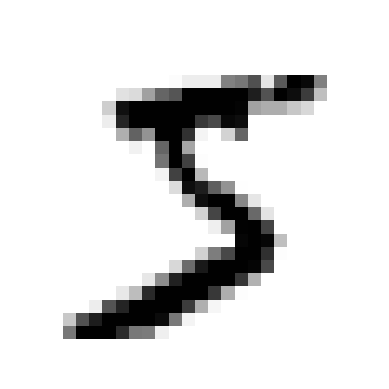

In [45]:
plot_digit(some_digit)

In [46]:
#and the label says
y[0]

'5'

In [47]:
#casting y to int from str
import numpy as np
y = y.astype(np.uint8)

In [48]:
#splitting the test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

Let's simplify the problem for now and only try to identify one digit. say 5.

In [49]:
y_train_5 = (y_train==5) #True for all 5s, False for all other digits
y_test_5 = (y_test==5)

### SGDC Classifier (Stochastic Gradient Descent Classifier)

This classifier has the advantage of being capable of handling very large datasets efficiently. It deals with training instances independently, one at a time.

In [50]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [51]:
sgd_clf.predict([some_digit])

array([ True])

Our models work's fine!

### Performance Measures

Evaluating a classifier is often trickier than evaluating a regressor.

In [52]:
#Cross validation
#Writing our own cross_val_score() method

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_folds = X_train[test_index]
  y_test_folds = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_folds)
  n_correct = sum(y_pred==y_test_folds)
  print(n_correct/len(y_pred))


0.95035
0.96035
0.9604


In [53]:
#using in-built validater

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [54]:
#creating a dumb classifier

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self

  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Over 90% accuracy? Absoluetly it mean there are only 10% of 5s in the dataset, and if you always guess image is not a 5, you will be right about 90% of the time. Hence accuracy is not the preffered performance measure for classifiers.

### Confusion Matrix

cross val predict is just like cross val score but instead of returning prediction score it returns prediction values.  
Moreover it return clean values which means prediction is made by a model that never saw the data during the training.


In [55]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [56]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [57]:
### Precision and recall
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [58]:
# f1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Choosing between precision and recall and adjusting the threshold

In [59]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [60]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [61]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.xlabel("Threshold")
  plt.legend()

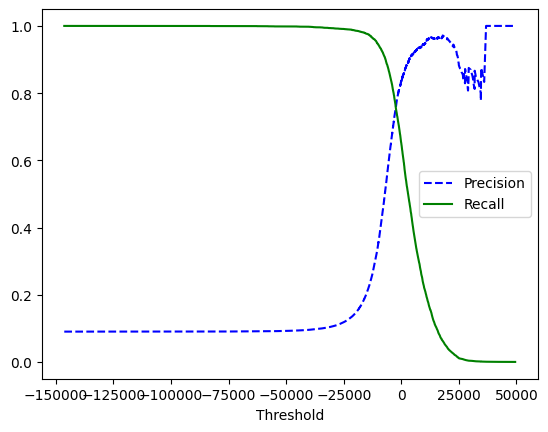

In [62]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Text(0, 0.5, 'Precision')

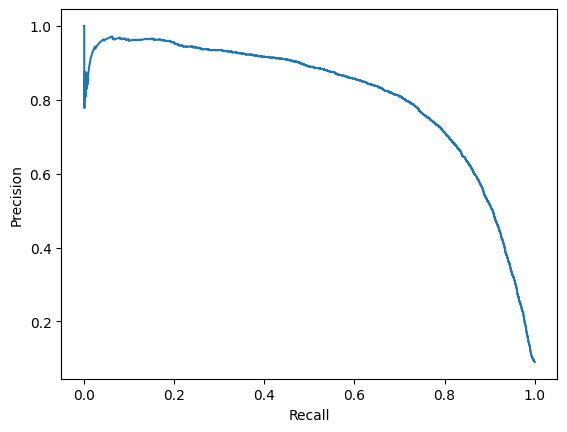

In [63]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")

In [64]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
print(threshold_90_precision)

3370.0194991439557


In [65]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [66]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### ROC Curve and AUC Score
ROC : Receiver operating characteristic  
AUC : Area Under the Curve

In [67]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

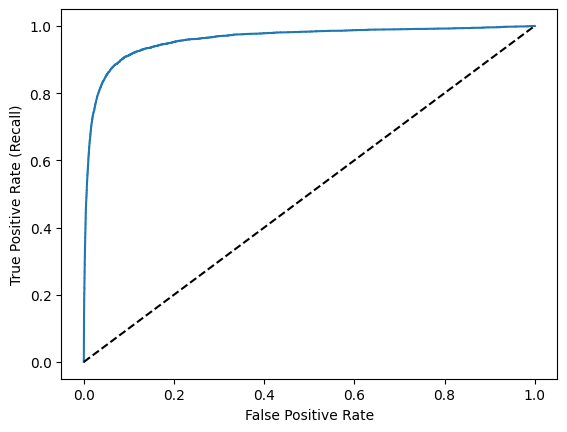

In [68]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, label=label)
  plt.plot([0,1],[0,1], 'k--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate (Recall)")

plot_roc_curve(fpr, tpr)

In [69]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [70]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,cv=3, method="predict_proba")

In [71]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

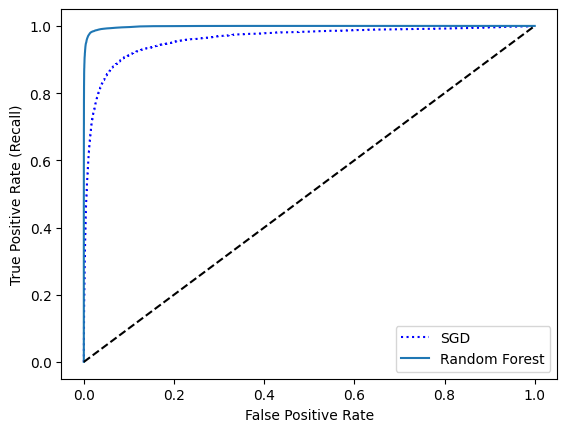

In [72]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right")

In [73]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## MultiClass Classification

In [74]:
#using svm
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [75]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [76]:
np.argmax(some_digit_scores)

5

In [77]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [78]:
svm_clf.classes_[5]

5

In [79]:
# Forcing to use one vs rest classifier
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [80]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [81]:
len(ovr_clf.estimators_)

10

In [82]:
# Using SGDClassifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [83]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [85]:
#scaling the features for better performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [86]:
#Using confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

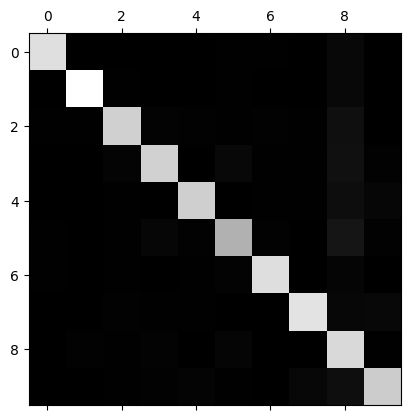

In [87]:
#visualizing confustion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [88]:
#visualizing the errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

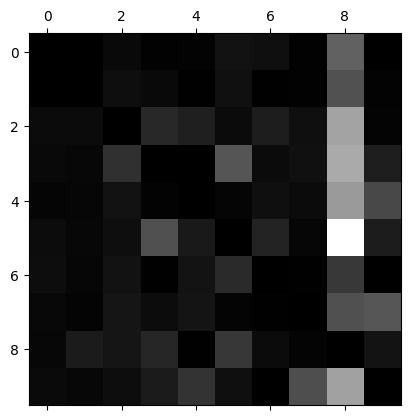

In [89]:
#fill diagonal with zeros
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

## Multilabel Classification

In [93]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [94]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [95]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [96]:
#Evaluating Multilabel classifier
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification

In [97]:
#adding noise to the MNIST Images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

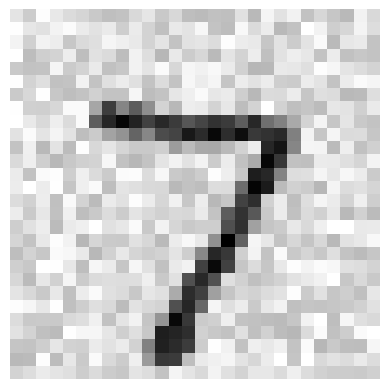

In [102]:
plot_digit(X_test_mod[0])

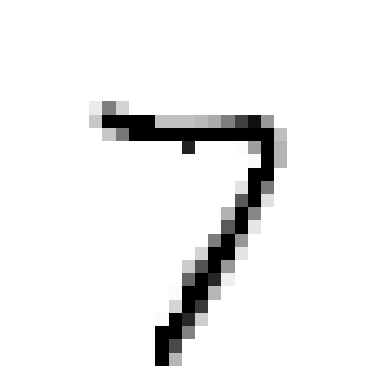

In [101]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)